# Nile Changepoint Problem

Camille Girard

MIT License: https://opensource.org/licenses/MIT

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from scipy.stats import norm, poisson

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint
import scipy as sp

import thinkbayes2
import thinkplot


from warnings import simplefilter
simplefilter('ignore', FutureWarning)
import pymc3 as pm
import theano.tensor as T


from matplotlib import pyplot as plt

## The Nile Problem

The nile rivers trends seem to have quickly changed at some point - given the data can we find where it happened and what happened at this point?

First use a changepoint algorithim in PyMC in order to identify when the mean changed and to have the normal distributions for the means in each half. 

In [3]:
import statsmodels.api as sm

data = sm.datasets.nile.load()

<class 'statsmodels.datasets.utils.Dataset'>

In [17]:
nile = sm.datasets.get_rdataset("Nile")
nile.title

'Flow of the River Nile'

In [18]:
df = nile.data
df.index = df.time
df.head()

,time,value
time,,
1871,1871,1120
1872,1872,1160
1873,1873,963
1874,1874,1210
1875,1875,1160


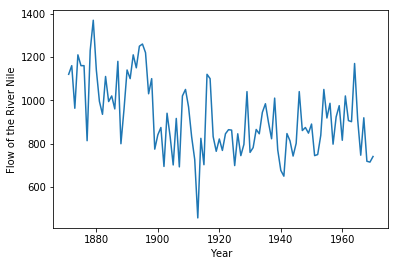

In [22]:
df.value.plot()
plt.xlabel('Year')
plt.ylabel('Flow of the River Nile');

In [23]:
data = df.value
print(data.head())

time
1871    1120
1872    1160
1873     963
1874    1210
1875    1160
Name: value, dtype: int64


## Model 1

We can start with a simple model that decides a changepoint and the change in the mean from either side, simplifying to keep the sigma to be constant from the data. 

In [27]:
niter = 10000
t = range(len(data))
with pm.Model() as change_point:
    cp = pm.DiscreteUniform('change_point', lower=0, upper=len(data))
    mu0 = pm.Uniform('mu0', 500, 1200)
    mu1 = pm.Uniform('mu1', 500, 1200)
    mu = T.switch(t < cp, mu0, mu1)
    Y_obs = pm.Normal('Y_obs', mu=mu, sd = data.std(), observed=data)
    trace = pm.sample(niter)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [change_point]
>NUTS: [mu1, mu0]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:13<00:00, 3023.55draws/s]
The acceptance probability does not match the target. It is 0.8998175802808565, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


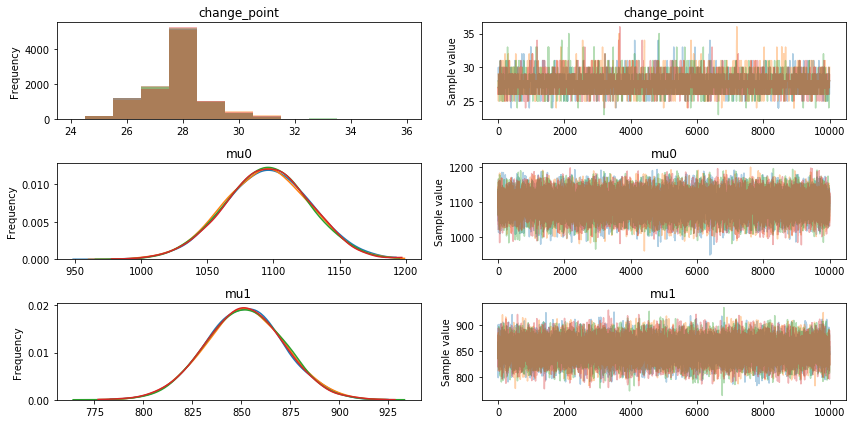

In [28]:
pm.traceplot(trace, varnames=['change_point', 'mu0', 'mu1']);

The changepoint here seems to be around 28. The mean shift down as expected from the plot, from higher before the changepoint to lower. This seems to fit the data well, but we assume the standard deviation stays the same. 

## Model 2

We can run the same model with a switch in standard deviation at the changepoint as well to find out if it changes.

In [29]:
t = range(len(data))
with pm.Model() as change_point:
    cp = pm.DiscreteUniform('change_point', lower=0, upper=len(data))
    mu0 = pm.Uniform('mu0', 500, 1200)
    mu1 = pm.Uniform('mu1', 500, 1200)
    st0 = pm.Uniform('st0', 0,600)
    st1 = pm.Uniform('st1', 0,600)
    mu = T.switch(t < cp, mu0, mu1)
    standard = T.switch(t < cp, st0, st1)
    Y_obs = pm.Normal('Y_obs', mu=mu, sd = standard, observed=data)
    trace = pm.sample(niter)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [change_point]
>NUTS: [st1, st0, mu1, mu0]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:17<00:00, 2440.66draws/s]
The number of effective samples is smaller than 10% for some parameters.


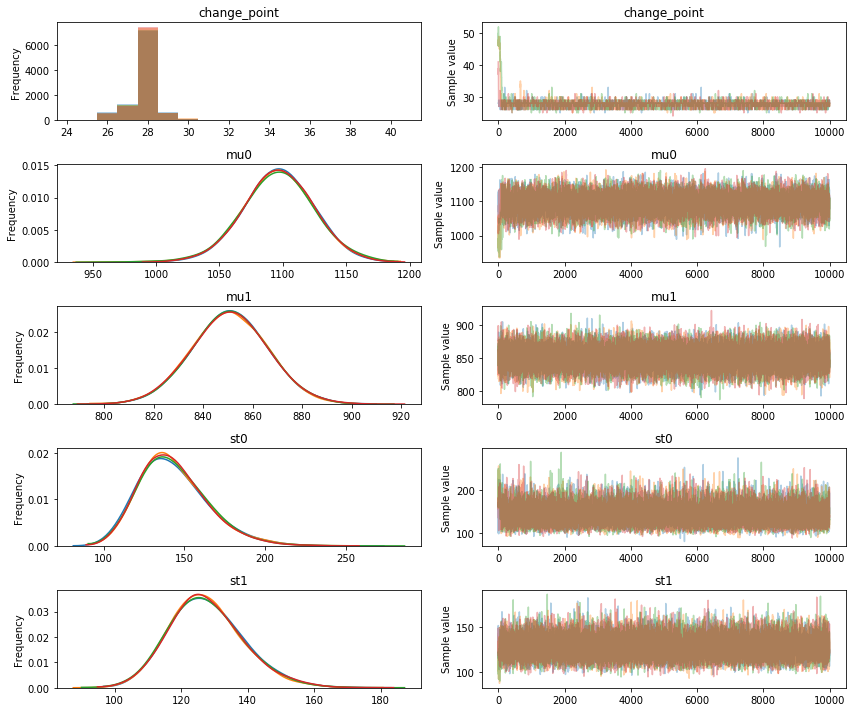

In [30]:
pm.traceplot(trace, varnames=['change_point', 'mu0', 'mu1', 'st0', 'st1']);

There is a clear changepoint at 28 given this method. The first mean is higher than the mean after the changepoint which fits with the data and the slight drop in the standard deviation is as expected. 

This model gives a clear changepoint and the change in mean, however it does not give the change in trend that seems to occur. It provides sufficient information to find the changepoint, however the change in mean does not tell much about the behavior change of the river. 

In order to see this we can run a regression model on either side of the changepoint.

## Model 3

It seems that there is a change in the trend before and after the changepoint. For this I will start by calculating a regression before at after 28, which is around where the change happens, and will see what this shows. This process is assuming that the changepoint is at 28 which is a simplification. 

In [34]:
first = nile.data['value'][0:28]
t1 = nile.data['time'][0:28]
second = nile.data['value'][28:]
t2 = nile.data['time'][28:];

The model has the slope, intercept and sigma that are found to closest fit the regression of that data.

In [35]:
with pm.Model() as model:
    slope = pm.Uniform('slope', -10, 10)
    inter = pm.Uniform('inter', 100, 10000)
    sigma = pm.Uniform('sigma', 0, 1000)

    y_est = slope * (t1-1870) + inter
    y = pm.Normal('y', mu=y_est, sd=sigma, observed= first)
    trace = pm.sample(4000, tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, inter, slope]
Sampling 4 chains: 100%|██████████| 32000/32000 [00:13<00:00, 2307.77draws/s]
The acceptance probability does not match the target. It is 0.5942597248254704, but should be close to 0.8. Try to increase the number of tuning steps.


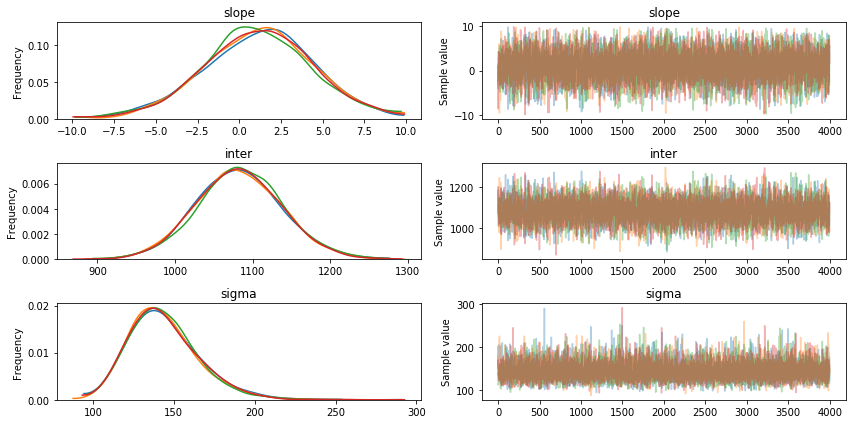

In [37]:
pm.traceplot(trace, varnames=['slope', 'inter', 'sigma']);

We can see that before the changepoint there is a high intercept and sigma is equal to the standard deviation and the slope is slightly negative. This fits the data as we would expect it to.

Now for the other half.

In [39]:
with pm.Model() as model:
    slope = pm.Uniform('slope', -10, 10)
    inter = pm.Uniform('inter', 100, 10000)
    sigma = pm.Uniform('sigma', 0, 1000)

    y_est = slope * (t2-1870) + inter
    y = pm.Normal('y', mu=y_est, sd=sigma, observed=second)
    trace = pm.sample(4000, tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, inter, slope]
Sampling 4 chains: 100%|██████████| 32000/32000 [00:18<00:00, 1776.13draws/s]


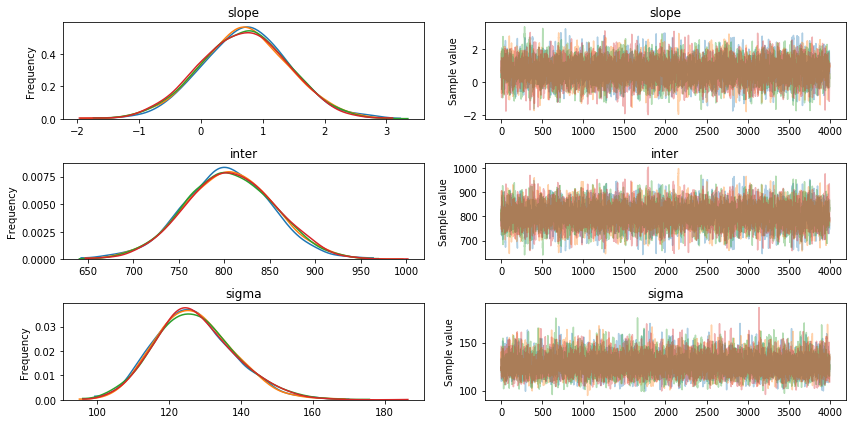

In [40]:
pm.traceplot(trace, varnames=['slope', 'inter', 'sigma']);

With a dividing time of 28, which is somewhere in the range of the bump of the changepoint there is an observed difference in the slope, intercept and the sigma. We can see that after the changepoint the intercept drops down and the sigma does as well. More importantly, the slope becomes slightly positive, showing a difference in the trends.

Instead of running the regressions on two seperate parts of the data we can combine it with a changepoint alogrithim in order to have a more complete model.

## Model 4

Instead of doing changepoint with the mean, use two of each of the regression parameters to find the changepoint and the components of each side of the changepoint. 

In [42]:
t = range(len(data))
with pm.Model() as model:
    cp = pm.DiscreteUniform('change_point', lower=0, upper=len(data))
    
    s1 = pm.Uniform('slope1', -15, 10)
    i1 = pm.Uniform('inter1', 850, 1400)
    si1 = pm.Uniform('sigma1', 100, 250)
    s2 = pm.Uniform('slope2', -4, 4)
    i2 = pm.Uniform('inter2', 400, 1200)
    si2 = pm.Uniform('sigma2', 80, 200)
    
    slope = T.switch(t < cp, s1, s2)
    inter = T.switch(t < cp, i1, i2)
    sigma = T.switch(t < cp, si1, si2)
    
    y_est = slope * (nile.data['time']-1870) + inter
    y = pm.Normal('y', mu=y_est, sd=sigma, observed=nile.data['value'])
    trace = pm.sample(10000, tune=10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [change_point]
>NUTS: [sigma2, inter2, slope2, sigma1, inter1, slope1]
Sampling 4 chains: 100%|██████████| 80000/80000 [01:22<00:00, 973.64draws/s] 
The acceptance probability does not match the target. It is 0.8828010680087787, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


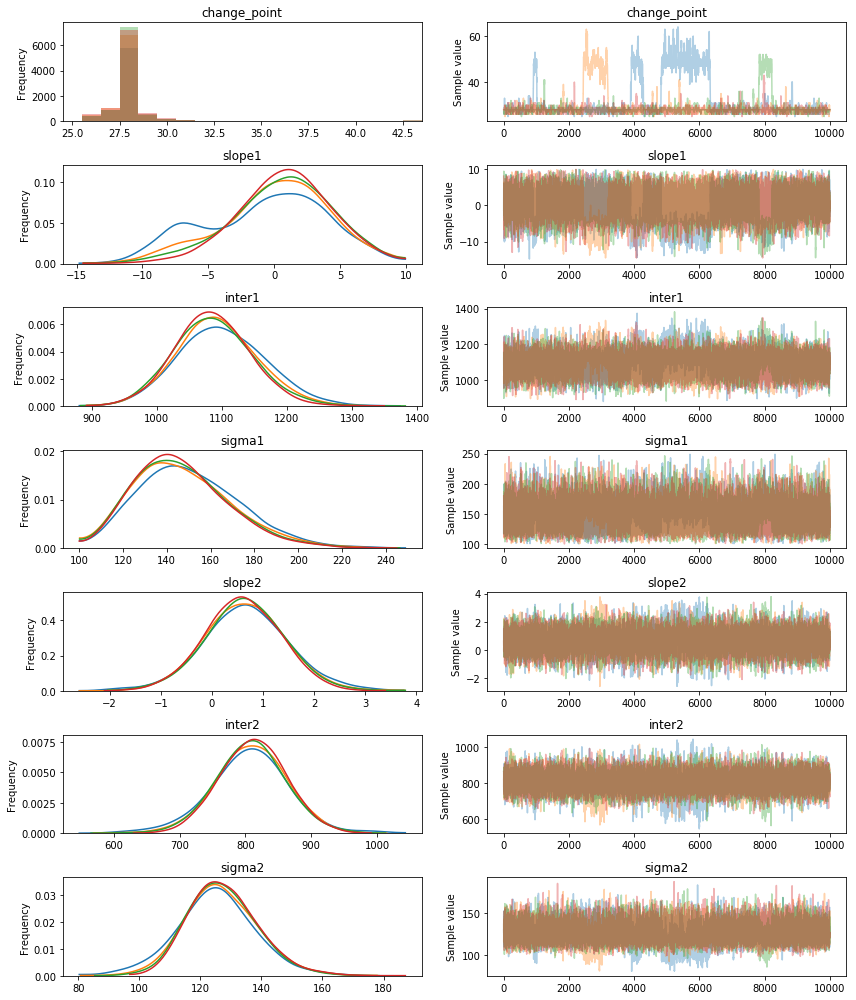

In [44]:
pm.traceplot(trace, varnames=['change_point', 'slope1', 'inter1', 
                              'sigma1', 'slope2', 'inter2', 'sigma2']);


By combining the changepoint and the regression model there is a clear changepoint location at 28. The slopes, intercepts and sigmas are very similar to those collected by running the regression on each side of the changepoint of the mu which shows consistancy between the two methods. One larger difference is that the slope 1 has some more fluctuation, it is less sure than when the data is divided, but still has a slope that is leaning into the slightly negative side. 

### We Have 2 Possible Changepoints...

The slope at the beginning of the changepoint being bimodal means that there are two potential changepoints. This is also shown in the changepoint data, where there is a small bump up later in the data for another possible changepoint. This is likely just a fluctuation in the data, but in order to observe how these two sides of either changepoint behave we will run the model with both halves.

Lets split the data at 40 for the beginning and start at 35 for the end and run the model

In [46]:
first_half = nile.data['value'][0:41]
time1 = nile.data['time'][0:41]
second_half = nile.data['value'][35:]
time2 = nile.data['time'][35:];

We run the same regression models that we just did on the two slices of the data 

In [59]:
t = range(len(first_half))
with pm.Model() as model:
    cp = pm.DiscreteUniform('change_point', lower=0, upper=len(first_half))
    
    s1 = pm.Uniform('slope1', -15, 10)
    i1 = pm.Uniform('inter1', 850, 1400)
    si1 = pm.Uniform('sigma1', 100, 250)
    s2= pm.Uniform('slope2', -10, 25)
    i2=pm.Uniform('inter2', -100, 1200)
    si2 = pm.Uniform('sigma2', 30, 200)
    
    slope = T.switch(t < cp, s1, s2)
    inter = T.switch(t < cp, i1, i2)
    sigma = T.switch(t < cp, si1, si2)
    
    y_est = slope * (time1 - 1870) + inter
    y = pm.Normal('y', mu=y_est, sd=sigma, observed=first_half)
    trace = pm.sample(10000, tune=10000, target_accept=0.95)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [change_point]
>NUTS: [sigma2, inter2, slope2, sigma1, inter1, slope1]
Sampling 4 chains: 100%|██████████| 80000/80000 [02:54<00:00, 457.30draws/s]
The acceptance probability does not match the target. It is 0.948288131725833, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5628511926611859, but should be close to 0.8. Try to increase the number of tuning steps.
There were 648 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.439041131949522, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


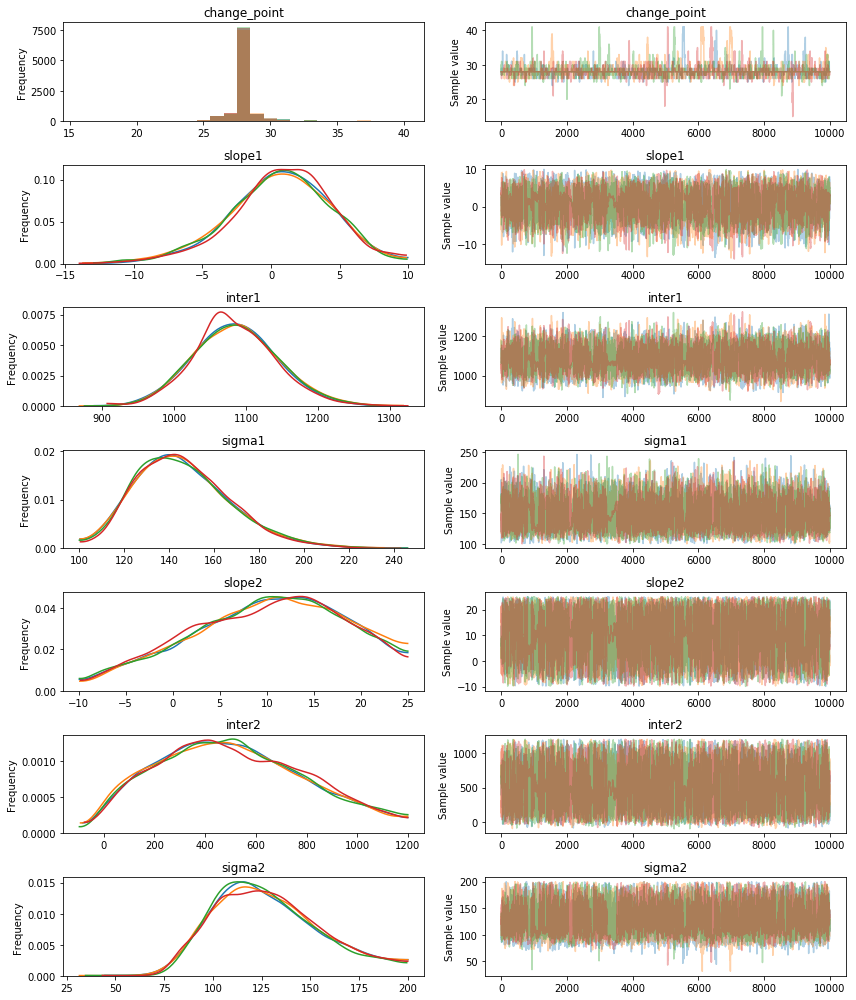

In [60]:
pm.traceplot(trace, varnames=['change_point', 'slope1', 'inter1', 
                              'sigma1', 'slope2', 'inter2', 'sigma2']);

With the changepoint analysis on the first points of the data until 40 the changepoint occurs at 28, where it was said to in the whole analysis. The slope for the beginning of the data is positive, which is not what was expected to happen here, it was expected to be negative. The slope afterwards becomes very positive which is also a little shocking, as it is at about 12. 

The reason these slopes are positive in part is because of the intercept for both. The intercept is lower than before, which will explain why the slope is increasing, meaning the model will still fit the data fairly well.

Not having a lot of data on either side can contribute to these suprising findings, the changepoint seems accurate with the data, however the regressions do not seems to fit as expected with the previous alogrithims.

In [57]:
t = range(len(second_half))
with pm.Model() as model:
    cp = pm.DiscreteUniform('change_point', lower=0, upper=len(second_half))
    
    s1 = pm.Uniform('slope1', -50, 50)
    i1 = pm.Uniform('inter1', 500, 1400)
    si1 = pm.Uniform('sigma1', 100, 400)
    s2= pm.Uniform('slope2', -4, 4)
    i2=pm.Uniform('inter2', 400, 1200)
    si2 = pm.Uniform('sigma2', 80, 200)
    
    slope = T.switch(t < cp, s1, s2)
    inter = T.switch(t < cp, i1, i2)
    sigma = T.switch(t < cp, si1, si2)
    
    y_est = slope * (time2 - 1906) + inter
    y = pm.Normal('y', mu=y_est, sd=sigma, observed=second_half)
    trace = pm.sample(20000, tune=20000, target_accept=0.95)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [change_point]
>NUTS: [sigma2, inter2, slope2, sigma1, inter1, slope1]
Sampling 4 chains: 100%|██████████| 160000/160000 [02:33<00:00, 1043.20draws/s]
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7153849797701389, but should be close to 0.8. Try to increase the number of tuning steps.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8840963979015328, but should be close to 0.8. Try to increase the number of tuning steps.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8990575107850438, but should be close to 0.8. Try to increase the number of

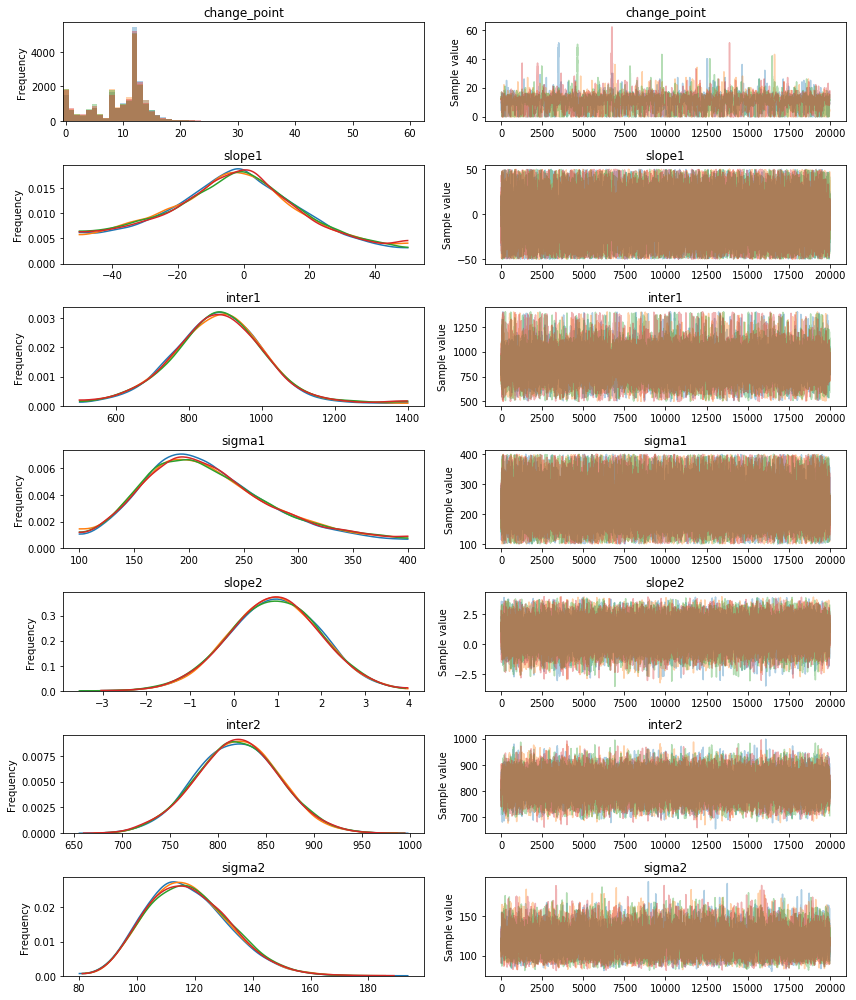

In [58]:
pm.traceplot(trace, varnames=['change_point', 'slope1', 'inter1', 
                              'sigma1', 'slope2', 'inter2', 'sigma2']);

When we do a changepoint anaylsis with the regression on the data after 35 points of the data the results are slightly different than with the entire data. There is a changepoint found at about 13 points in, meaning at about 48 in the entire data. Between 35 and 48 there seems to be a flat zone, where the slope is about 0. Afterwards the slope goes up to about 1 which is slightly higher than the second half slope with the whole data. This shows there is likely a flat period and then the tide begins to increase.

It is possible that this data has two changepoints, and that one is a much greater change in trend than the other. It is difficult to make models that fit the data very well with the limited data that is given, and this makes the models that split the data even harder to understand. For this reason the second changepoint could very likely be just a fluctuation in the model, which is likely due to the data being of a river. This would lead to the conclusion that 28 years into data collection the nile shifted from a downward slope to a slightly upward one.